## 상관분석 및 총점 계산
 - 1. 일평균충전량을 기준으로 상관분석 수행 (원본 값을 MinMax 정규화하여 총점 계산)
 - 2. 총점및 순위 계산

### 1. 읽어들일 파일명 지정 ==> 수정필요

In [1]:
########### file_name 선언 ##################################
전처리데이터셋 = '남양주_전처리데이터셋.csv'
충전현황셋 = '충전량현황종합_전처리.csv' 
#############################################################

### 2. 화면에 출력되는 칼럼명을 확인한 후, 필요한 칼럼명을 복사하여 붙여넣기 (수정 불필요)

In [2]:
import pandas as pd
df = pd.read_csv(f'{전처리데이터셋}', header=0, encoding='cp949', engine='python')
df.set_index('gid', inplace=True)
전체칼럼 = df.columns.tolist()
print ("여기칼럼명을 확인하신 후 점수계산에 필요한 칼럼명을 복사 하세요.\n", 전체칼럼)

여기칼럼명을 확인하신 후 점수계산에 필요한 칼럼명을 복사 하세요.
 ['전기차', '건물1', '건물2', '건물3', '관공서', '교통량', '경제인구', '변압기', '전기관리자', '공공건물', '충전소', '주차장', 'lon', 'lat']


### 3. 하단에 있는 "점수칼럼"에 점수로 환산할 대상인 칼럼을 수정하도록 함 ==> 수정 필요

In [3]:
점수칼럼 = ['전기차', '건물1', '건물2', '건물3', '관공서', '경제인구']
print("입력한 점수컬럼명은 다음과 같음\n", 점수칼럼)

입력한 점수컬럼명은 다음과 같음
 ['전기차', '건물1', '건물2', '건물3', '관공서', '경제인구']


### 4. 이하 별도 언급 시까지 수정 불필요

In [4]:
################## 1. QGIS에서 작업한 전처리 결과 CSV 읽기 ####################################################
pre_process_set = pd.read_csv(f'{전처리데이터셋}', header=0, encoding='cp949', engine='python')
pre_process_set = pre_process_set.sort_values(by='gid')

# Null 이 있을 수 있는 칼럼은 Null을 0로 변경
pre_process_set.fillna(0, inplace=True)
################## 1. QGIS에서 작업한 전처리 결과 CSV 읽기 끝###################################################


################## 2. 충전현황 파일 처리 ######################################################################
charge_summary = pd.read_csv(f'{충전현황셋}', header=0, encoding='cp949', engine='python')
charge_summary = charge_summary.sort_values(by='gid')
charge_summary.fillna(0, inplace=True)

charge_summary = charge_summary.loc[:,['gid','충전소명','일평균충전량','일평균이용수','구분']]

# 일평균충전량이 0이거나 데이터가 없는 것은 열외시킴
charge_summary.drop(index = charge_summary[charge_summary['일평균충전량']==0].index, inplace=True)   
################## 2. 충전현황 파일 처리 끝#####################################################################



################## 정규화 ## 시작 ##################################################################################
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# 점수칼럼 정규화
norm = pre_process_set.copy()
norm.fillna(0, inplace=True)
norm.set_index('gid', inplace=True)

norm[점수칼럼] = scaler.fit_transform(norm.loc[:,점수칼럼])
norm.reset_index(inplace=True)

# 충전소 일평균치 정규화
charge_summary[['일평균충전량','일평균이용수']] = scaler.fit_transform(charge_summary.loc[:,['일평균충전량','일평균이용수']])


# 상관관계를 위한 데이터셋 준비 (정규화)
corr_prepared = charge_summary.merge(norm, on=['gid'], how='left')
################## 정규화 ## 끝 ##################################################################################


# 상관관계 함수 미리 선언

#피어슨 상관관계 함수
def corr_p (df, col):  #col=['분석할 칼럼']
    df_ = df.loc[:,col]
    display(df_.corr(method='pearson').iloc[0:2, 2:].style.highlight_max(axis='columns'))    
    return None

#스피어만 상관관계 함수
def corr_s (df, col):  #col=['분석할 칼럼']
    df_ = df.loc[:,col]
    display("스피어만", df_.corr(method='spearman').iloc[0:2, 2:].style.highlight_max(axis='columns'))
    return None

# PV값 및 계수 확인용 함수
def pv (lm):
    pv = lm.pvalues.to_frame()
    pv.reset_index(inplace=True)
    pv.rename(columns={'index': "항목명", 0: "p-value"}, inplace=True)    
    rate = lm.params.to_frame()
    rate.reset_index(inplace=True)
    rate.rename(columns={'index': "항목명", 0: "계수"}, inplace=True)
    merged = pv.merge(rate, on='항목명', how='left')
    return (merged)

X = '+'.join(점수칼럼)   # 상관계수에 포함시킬 항목 선언

상관칼럼 = 점수칼럼.copy()
상관칼럼.insert(0, '일평균충전량')
상관칼럼.insert(1, '일평균이용수')
상관칼럼


######  상관관계 전체 보기 ########################################################################
corr_prepared.corr(method='pearson')

#### 전체 충전소 ###############################################################################
display("전체 충전소", corr_p(corr_prepared, 상관칼럼))

#### 아파트 충전소 #############################################################################
apt = corr_prepared[corr_prepared['구분']=='아파트']
display("아파트충전소", corr_p(apt, 상관칼럼))

#### 비아파트 충전소 ###########################################################################
Napt = corr_prepared[corr_prepared['구분']!='아파트']
display("비아파트충전소", corr_p(Napt, 상관칼럼))


import statsmodels.formula.api as smf
######  상관 계수 분석 ########################################################################
Y = '일평균충전량'

# linear regression 그래프의 절편을 0으로 맞추는 경우 ==> -1이 의미하는 것이 절편을 영으로 하라는 옵션임
# 통계결과를 확인후 절편을 0으로 할지 아니면 유지할지는 Adj. R-squared가 높은 것으로 선택하면 됨

lm = smf.ols(formula= f'{Y} ~ -1 + {X}', data=corr_prepared).fit()
# 절편을 유지하는 경우
#lm = smf.ols(formula= f'{Y} ~ {X}', data=corr_prepared).fit()

display("통계결과", lm.summary())
coef = pv(lm)

# 상관계수 복사
rate = coef.copy()
rate.reset_index(drop=True, inplace=True)
rate["계수"] += 1
display("상관계수", rate)

# 계수 적용할 칼럼만 추출
###### P-Value 커트라인 지정 ############
cut_over = 1
########################################
scoring = norm.copy()
scoring = scoring.sort_values(by='gid')
scoring.set_index('gid', inplace=True)
col = rate.iloc[:,0].tolist() 
scoring = scoring.loc[:,col]
scoring.reset_index(inplace=True)
scoring.sort_values(by='gid', inplace=True)

# 계수 만큼 곱하기 계산수행
for i in range(len(rate)):
    if(rate.iloc[i,1] <= cut_over):
        scoring[rate.iloc[i,0]] = scoring[rate.iloc[i,0]] * (rate.iloc[i,2])
    else:
        None   
        
                
# 총점 계산 (총점=예싱충전량)
scoring['예상충전량'] = scoring.sum(1)

# 등수 계산 
scoring['순위'] = scoring['예상충전량'].rank(method='dense', ascending=False).astype(int)


# 비점수칼럼을 결과에 붙이기
editing = pre_process_set.copy()
editing.set_index('gid', inplace=True)
editing.update(scoring.set_index('gid'))
editing.reset_index(inplace=True)

col_to_use = scoring.loc[:, ['gid','예상충전량','순위']]
editing = editing.merge(col_to_use, on='gid', sort=False)

# 칼럼 순서 조정 ==> 비점수칼럼 죄측, 점수캄럼 우측, 위경도는 최좌측
점수set = set(점수칼럼)
전체set = set(전체칼럼)
비점수set = 전체set - 점수set - set({'lat', 'lon'})
비점수칼럼 = list(비점수set)

# 칼럼 순서 조정 ==> 비점수칼럼 죄측, 점수캄럼 우측
col_order = ['lat', 'lon'] + 비점수칼럼 + 점수칼럼 + ['예상충전량','순위']
editing.set_index('gid', inplace=True)
editing = editing[col_order]
editing.reset_index(inplace=True)
result = editing.sort_values(by='순위')


# 최종 결과 CSV 파일쓰기
result.to_csv(r'결과(scale).csv',index=False, sep=',', encoding='cp949')

display(result)

,전기차,건물1,건물2,건물3,관공서,경제인구
일평균충전량,0.531648,0.278905,0.05481,0.43858,0.112171,-0.269312
일평균이용수,0.548825,0.26493,0.0664205,0.405558,0.112275,-0.244932


'전체 충전소'

None

,전기차,건물1,건물2,건물3,관공서,경제인구
일평균충전량,0.605715,-0.0918314,-0.0130547,nan,-0.0361155,0.0814778
일평균이용수,0.589804,-0.157913,0.013951,nan,-0.0855307,0.051734


'아파트충전소'

None

,전기차,건물1,건물2,건물3,관공서,경제인구
일평균충전량,0.603552,0.344218,-0.0477128,0.363063,0.0843016,-0.007335
일평균이용수,0.62242,0.320824,-0.035287,0.298262,0.0951645,0.107461


'비아파트충전소'

None

'통계결과'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 일평균충전량   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     27.53
Date:                Thu, 13 Dec 2018   Prob (F-statistic):           4.91e-15
Time:                        15:38:41   Log-Likelihood:                 38.653
No. Observations:                  62   AIC:                            -65.31
Df Residuals:                      56   BIC:                            -52.54
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
전기차            0.8938      0.134      6.647      0.000       0.624       1.163
건물1            0.1650      0.128      1.286      0.204      -0.092       0.422
건물2            0.4152      0.252      1.645      0.106      -0.090       0.921
건물3            0.3659      0.057      6.393      0.000       0.251       0.481
관공서            0.2847      0.095      2.991      0.004       0.094       0.475
경제인구           0.0299      0.058      0.519      0.606      -0.085       0.145
==============================================================================
Omnibus:                        1.576   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.455   Jarque-Bera (JB):                0.898
Skew:                           0.239   Prob(JB):                        0.638
Kurtosis:                       3.345   Cond. No.                         5.69
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'상관계수'

,항목명,p-value,계수
0,전기차,1.324955e-08,1.893822
1,건물1,2.038213e-01,1.165041
2,건물2,1.055998e-01,1.415195
3,건물3,3.466228e-08,1.365924
4,관공서,4.124035e-03,1.284689
5,경제인구,6.057185e-01,1.029887


,gid,lat,lon,교통량,주차장,충전소,공공건물,전기관리자,변압기,전기차,건물1,건물2,건물3,관공서,경제인구,예상충전량,순위
6019,다사82bb61aa,37.649453,127.305869,2431.468,0.0,0,1,7,10,0.000000,0.245272,0.000000,1.365924,1.284689,0.084281,2.980166,1
2626,다사74bb59ba,37.635749,127.215233,6933.113,29.0,1,6,6,8,1.893822,0.352578,0.000000,0.000000,0.428230,0.164412,2.839041,2
1696,다사71bb68ba,37.716782,127.180884,910.982,0.0,0,0,16,12,0.000000,0.521203,0.202171,1.365924,0.000000,0.537929,2.627226,3
969,다사69ba56aa,37.604044,127.155875,3234.926,37.0,0,0,5,1,0.072839,0.137965,0.404342,1.365924,0.000000,0.560595,2.541666,4
1591,다사71ba61bb,37.655934,127.178310,1659.468,0.0,0,2,11,9,0.000000,0.858452,0.202171,0.000000,1.284689,0.096093,2.441405,5
2286,다사73bb59ab,37.633468,127.203908,11663.968,0.0,0,0,4,11,0.000000,0.521203,0.404342,1.365924,0.000000,0.122910,2.414378,6
658,다사68ab61aa,37.649068,127.141498,2919.322,0.0,0,0,11,49,0.000000,0.521203,0.202171,1.365924,0.000000,0.238796,2.328093,7
4947,다사80ba61bb,37.656169,127.280343,2645.041,0.0,0,1,3,9,0.072839,0.045988,0.202171,1.365924,0.428230,0.105990,2.221142,8
5903,다사82ba61ab,37.651702,127.303029,2612.344,44.0,1,1,7,12,0.000000,0.413896,0.202171,1.365924,0.000000,0.197294,2.179285,9
1692,다사71bb67ba,37.707768,127.180922,10883.351,0.0,1,0,6,19,0.000000,0.674498,0.000000,1.365924,0.000000,0.002235,2.042656,10


### 5.1 임야토지 파일이 있는 경우에만 실행
- 파일이 없는 경우에는 실행하지 말고 Skip
- 파일이 있는 경우에는 토지격자 파일명을 갖고 있는 파일이름으로 수정 필요

In [5]:
## 토지임야정보 붙이기
########### 추가로 file 선언 ###########################################################
토지격자 = '남양주_국공토지격자.csv'
#######################################################################################

### 5.2. 수정 불필요

In [6]:
if (not 토지격자):
    print ('격자주소 정보가 없어서 생략합니다\n')
else:
        토지 = pd.read_csv(토지격자, header=0, encoding='cp949', engine='python')
        토지.sort_values(by='gid', inplace=True)
        gid_토지 = 토지.groupby('gid')[['gid','지목','주소','소유구분']].head(len(토지)+1)
        
        # GID 내 국유토지가 몇 건 있는지 카운팅
        국유토지_count = gid_토지.groupby('gid')[['지목']].count()
        국유토지_count.reset_index(inplace=True)
        국유토지_count.rename(columns={"지목": "국유토지"}, inplace=True)
        
        # 국유토지가 gid당 몇개 인지 결과에 붙이기
        final = result.copy()
        final = final.merge(국유토지_count, on=['gid'], how='left', sort=False)
        final['국유토지'] = final['국유토지'].fillna(0).astype(int)
        
        final.set_index(['gid','국유토지'], inplace=True)
        final.reset_index(inplace=True)
        
        # 최종 결과 CSV 파일쓰기
        final.to_csv('결과_남양주(scale).csv', index=False, sep=',', encoding='cp949')
        display(final)

,gid,국유토지,lat,lon,교통량,주차장,충전소,공공건물,전기관리자,변압기,전기차,건물1,건물2,건물3,관공서,경제인구,예상충전량,순위
0,다사82bb61aa,59,37.649453,127.305869,2431.468,0.0,0,1,7,10,0.000000,0.245272,0.000000,1.365924,1.284689,0.084281,2.980166,1
1,다사74bb59ba,50,37.635749,127.215233,6933.113,29.0,1,6,6,8,1.893822,0.352578,0.000000,0.000000,0.428230,0.164412,2.839041,2
2,다사71bb68ba,35,37.716782,127.180884,910.982,0.0,0,0,16,12,0.000000,0.521203,0.202171,1.365924,0.000000,0.537929,2.627226,3
3,다사69ba56aa,13,37.604044,127.155875,3234.926,37.0,0,0,5,1,0.072839,0.137965,0.404342,1.365924,0.000000,0.560595,2.541666,4
4,다사71ba61bb,95,37.655934,127.178310,1659.468,0.0,0,2,11,9,0.000000,0.858452,0.202171,0.000000,1.284689,0.096093,2.441405,5
5,다사73bb59ab,48,37.633468,127.203908,11663.968,0.0,0,0,4,11,0.000000,0.521203,0.404342,1.365924,0.000000,0.122910,2.414378,6
6,다사68ab61aa,64,37.649068,127.141498,2919.322,0.0,0,0,11,49,0.000000,0.521203,0.202171,1.365924,0.000000,0.238796,2.328093,7
7,다사80ba61bb,30,37.656169,127.280343,2645.041,0.0,0,1,3,9,0.072839,0.045988,0.202171,1.365924,0.428230,0.105990,2.221142,8
8,다사82ba61ab,32,37.651702,127.303029,2612.344,44.0,1,1,7,12,0.000000,0.413896,0.202171,1.365924,0.000000,0.197294,2.179285,9
9,다사71bb67ba,10,37.707768,127.180922,10883.351,0.0,1,0,6,19,0.000000,0.674498,0.000000,1.365924,0.000000,0.002235,2.042656,10


### 6.1. 격자센터주소 파일이 있는 경우에만 실행
- 하단 격자주소셋 파일명 수정 필요

In [7]:
# 격자의 센터주소 붙이기 
########### 추가로 file 선언 ###################################################################
격자주소셋 = '남양주_격자센터주소_전처리.csv'    # 여기 수정
###############################################################################################

### 6.2. 격자센터주소 파일이 있는 경우에만 실행, 수정 불필요

In [8]:
if (not 격자주소셋):
    print ('격자주소 정보가 없어서 생략합니다\n')
else:
    격자주소 = pd.read_csv(격자주소셋, header=0, encoding='cp949', engine='python')
    final = final.merge(격자주소, on='gid', sort=False)
    
    # 최종 결과 CSV 파일쓰기
    final.to_csv('결과_남양주(scale).csv', index=False, sep=',', encoding='cp949')
    display(final)

,gid,국유토지,lat,lon,교통량,주차장,충전소,공공건물,전기관리자,변압기,전기차,건물1,건물2,건물3,관공서,경제인구,예상충전량,순위,센터주소
0,다사82bb61aa,59,37.649453,127.305869,2431.468,0.0,0,1,7,10,0.000000,0.245272,0.000000,1.365924,1.284689,0.084281,2.980166,1,경기도 남양주시 화도읍 창현리 751
1,다사74bb59ba,50,37.635749,127.215233,6933.113,29.0,1,6,6,8,1.893822,0.352578,0.000000,0.000000,0.428230,0.164412,2.839041,2,경기도 남양주시 금곡동 185-10
2,다사71bb68ba,35,37.716782,127.180884,910.982,0.0,0,0,16,12,0.000000,0.521203,0.202171,1.365924,0.000000,0.537929,2.627226,3,경기도 남양주시 진접읍 장현리 643-28
3,다사69ba56aa,13,37.604044,127.155875,3234.926,37.0,0,0,5,1,0.072839,0.137965,0.404342,1.365924,0.000000,0.560595,2.541666,4,경기도 남양주시 다산동 669
4,다사71ba61bb,95,37.655934,127.178310,1659.468,0.0,0,2,11,9,0.000000,0.858452,0.202171,0.000000,1.284689,0.096093,2.441405,5,경기도 남양주시 진건읍 용정리 794-53
5,다사73bb59ab,48,37.633468,127.203908,11663.968,0.0,0,0,4,11,0.000000,0.521203,0.404342,1.365924,0.000000,0.122910,2.414378,6,경기도 남양주시 금곡동 682-21
6,다사68ab61aa,64,37.649068,127.141498,2919.322,0.0,0,0,11,49,0.000000,0.521203,0.202171,1.365924,0.000000,0.238796,2.328093,7,경기도 남양주시 퇴계원면 퇴계원리 297-2
7,다사80ba61bb,30,37.656169,127.280343,2645.041,0.0,0,1,3,9,0.072839,0.045988,0.202171,1.365924,0.428230,0.105990,2.221142,8,경기도 남양주시 화도읍 묵현리 374
8,다사82ba61ab,32,37.651702,127.303029,2612.344,44.0,1,1,7,12,0.000000,0.413896,0.202171,1.365924,0.000000,0.197294,2.179285,9,경기도 남양주시 화도읍 창현리 500-5
9,다사71bb67ba,10,37.707768,127.180922,10883.351,0.0,1,0,6,19,0.000000,0.674498,0.000000,1.365924,0.000000,0.002235,2.042656,10,경기도 남양주시 진접읍 연평리 98-36


### 7.1 지도로 보기 선택 사항 - 인터넷 되는 경우에만 실행
- 상단에서 도출된 결과값들 중에서 상위 3개만 지도로 보여주기
- Google Map이 보여지며, 마우스로 스크롤하면 지도 크기가 Zoom 됨
- 이를 위해서 Anaconda Promprt 창을 열고 아래 함수를 복사하여 그대로 엔터
 - pip install folium

#### 수정필요

In [9]:
# 보고 싶은 상위권 갯수를 입력하세요
지도보기갯수 = 3   # 보고싶은 상위권 갯수를 여기에 입력, 만약 3이면 최상위 3개만 보겠다는 의미

### 7.2 수정 불필요

In [10]:
# 지도로 보여주기
import folium
print(f"보고자 하는 상위권 갯수는 {지도보기갯수}개 입니다.")
for i in range(지도보기갯수):
    지도보기 = folium.Map(location=[final.loc[i,'lat'],final.loc[i,'lon']], zoom_start = 16)
    folium.Marker([final.loc[i,'lat'],final.loc[i,'lon']]).add_to(지도보기)
    j = i+1
    display(f'상위 {j}번째 격자의 센터 위치 보기', 지도보기)

보고자 하는 상위권 갯수는 3개 입니다.


'상위 1번째 격자의 센터 위치 보기'

'상위 2번째 격자의 센터 위치 보기'

'상위 3번째 격자의 센터 위치 보기'

### 8. Box Plot 보기 선택 사항 - 수정 불필요
- 상기 선택사항 실행여부와 무관하게 9번은 실행가능함
- 값들이 몇점대에 몰려 있는지 확인해보는 Box Plot 그래프
- 맨 하단부에 몰려 있을 가능성이 높음. 이유는 절반이상이 0점이기 때문

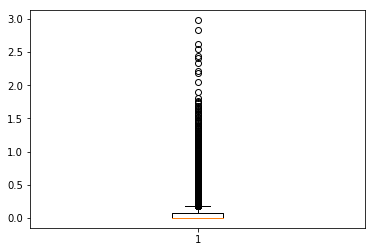

In [11]:
#참고) 총점 분포도
import matplotlib.pyplot as plt
plt.figure()
plt.boxplot(final['예상충전량'])
plt.show()

끝